# GAT-LSTM Load Disaggregation


In [1]:
import os, sys, yaml, torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from torch.utils.data import DataLoader

sys.path.append('../src')
sys.path.append('../configs')

from utils import set_seed, visualize_actual_vs_predicted, save_model, classification
from data_preparation import load_and_process_data, create_star_edge_index
from dataset import SequenceDataset, PredictDataset
from model import GATLSTMDisaggregator, weights_init
from train import train_model, evaluate


In [2]:
with open('../configs/config.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)


In [3]:
set_seed(config.get('seed', 42))
# device = torch.device('cuda:0' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device


device(type='cpu')

In [4]:
file_path = config['file_path']
devices = config['devices']
data_cfg = config['data']
train_cfg = config['training']
model_cfg = config['model']
lookback = data_cfg['lookback']
horizon = data_cfg['horizon']
include_residual = data_cfg.get('include_residual', True)


In [5]:
raw_data = load_and_process_data(file_path, devices, rolling_window=data_cfg.get('rolling_window', 1))


# subset_ratio = 0.01
# n_rows = int(len(raw_data) * subset_ratio)
# raw_data = raw_data.iloc[:n_rows].reset_index(drop=True)

print(f'Dataset rows after preprocessing: {len(raw_data)}')

Dataset rows after preprocessing: 1048575


In [6]:
def filter_raw_data(dataframe, devices, lookback):
    """只保留至少有一台设备为 ON 的时间段，并补齐窗口起点前的 lookback-1 个时间点。"""
    device_states = []
    for dev in devices:
        values = dataframe[dev].to_numpy(dtype=float)
        state_col = f"{dev}_State"
        if state_col in dataframe.columns:
            state = (
                dataframe[state_col]
                .astype(str)
                .str.strip()
                .str.upper()
                .map({"ON": 1.0, "OFF": 0.0})
                .fillna(0.0)
                .to_numpy()
            )
        else:
            state = (values > 15.0).astype(float)  # 阈值按需调整
        device_states.append(state)

    device_states = np.stack(device_states, axis=1)
    has_device_on = device_states.sum(axis=1) > 0

    keep_idx = np.where(has_device_on)[0]
    if len(keep_idx) == 0:
        return dataframe.reset_index(drop=True)

    lookback = max(int(lookback), 1)
    expanded_idx = set()
    for idx in keep_idx:
        start = max(0, idx - (lookback - 1))
        expanded_idx.update(range(start, idx + 1))

    expanded_idx = sorted(expanded_idx)
    return dataframe.iloc[expanded_idx].reset_index(drop=True)

filtered_data = filter_raw_data(raw_data, devices, lookback)
filtered_data

,Aggregate,Hour,Unknown,Unknown_State,WashingMachine,WashingMachine_State,Dishwasher,Dishwasher_State,Dryer,Dryer_State,Television,Television_State,Computer,Computer_State
0,281.6,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
1,282.2,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
2,289.8,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
3,297.4,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
4,305.0,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526834,2447.2,19,0.0,OFF,0.0,OFF,1886.8,ON,14.0,OFF,154.0,ON,5.0,OFF
526835,2471.2,19,0.0,OFF,0.0,OFF,1888.0,ON,14.0,OFF,154.2,ON,5.0,OFF
526836,2482.2,19,0.0,OFF,0.0,OFF,1886.4,ON,14.0,OFF,154.0,ON,4.8,OFF
526837,2480.8,19,0.0,OFF,0.0,OFF,1886.4,ON,14.0,OFF,154.0,ON,4.8,OFF


In [7]:
subset_ratio = 0.8
n_rows = int(len(filtered_data) * subset_ratio)
raw_data = filtered_data.iloc[:n_rows].reset_index(drop=True)

In [8]:
raw_data

,Aggregate,Hour,Unknown,Unknown_State,WashingMachine,WashingMachine_State,Dishwasher,Dishwasher_State,Dryer,Dryer_State,Television,Television_State,Computer,Computer_State
0,281.6,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
1,282.2,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
2,289.8,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
3,297.4,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
4,305.0,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421466,243.6,11,2.0,OFF,2.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,41.0,ON
421467,243.6,11,2.0,OFF,2.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,41.0,ON
421468,243.6,11,2.0,OFF,2.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,41.0,ON
421469,243.8,11,2.0,OFF,2.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,41.0,ON


In [9]:
split_idx = int(len(raw_data) * 0.8)
train_df = raw_data.iloc[:split_idx].reset_index(drop=True)
val_df = raw_data.iloc[max(0, split_idx - lookback):].reset_index(drop=True)
print(f'Train rows: {len(train_df)}, Validation rows: {len(val_df)}')


Train rows: 337176, Validation rows: 84319


In [10]:
train_dataset = SequenceDataset(
    train_df,
    devices=devices,
    lookback=lookback,
    horizon=horizon,
    include_residual=include_residual,
)
val_dataset = SequenceDataset(
    val_df,
    devices=devices,
    lookback=lookback,
    horizon=horizon,
    feature_scaler=train_dataset.get_feature_scaler(),
    label_scaler=train_dataset.get_label_scaler(),
    include_residual=include_residual,
)
device_pos_weight = train_dataset.get_device_pos_weight()
train_loader = DataLoader(train_dataset, batch_size=train_cfg['batch_size'], shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=train_cfg['batch_size'], shuffle=False)


In [11]:
metadata = train_dataset.get_metadata()
edge_index = create_star_edge_index(metadata.num_nodes, center=0, include_self_loops=True)
model = GATLSTMDisaggregator(
    metadata=metadata,
    public_feature_dim=train_dataset.public_feature_dim,
    horizon=horizon,
    embedding_dim=model_cfg['embedding_dim'],
    gat_hidden_dim=model_cfg['gat_hidden'],
    gat_heads=model_cfg['gat_heads'],
    gat_dropout=model_cfg['gat_dropout'],
    lstm_hidden_dim=model_cfg['lstm_hidden'],
    lstm_layers=model_cfg['lstm_layers'],
    lstm_dropout=model_cfg['lstm_dropout'],
).to(device)
model.apply(weights_init)
model


GATLSTMDisaggregator(
  (node_embedding): Embedding(8, 16)
  (gat1): GATConv(19, 64, heads=4)
  (gat2): GATConv(256, 64, heads=1)
  (gat_activation): ELU(alpha=1.0)
  (gat_dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (lstm_dropout): Dropout(p=0.1, inplace=False)
  (on_head): Linear(in_features=256, out_features=1, bias=True)
  (power_head): Linear(in_features=256, out_features=1, bias=True)
  (residual_head): Linear(in_features=256, out_features=1, bias=True)
)

In [12]:
opt_cfg = train_cfg['optimizer']
opt_type = opt_cfg['type'].lower()
if opt_type == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=opt_cfg['lr'], weight_decay=opt_cfg.get('weight_decay', 0.0))
elif opt_type == 'adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=opt_cfg['lr'], weight_decay=opt_cfg.get('weight_decay', 0.0))
else:
    raise NotImplementedError(f"Unsupported optimizer {opt_cfg['type']}")

scheduler = None
sched_cfg = train_cfg.get('scheduler')
if sched_cfg and sched_cfg.get('type') == 'ReduceLROnPlateau':
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        factor=sched_cfg.get('factor', 0.5),
        patience=sched_cfg.get('patience', 5),
        verbose=True
    )
loss_weights = train_cfg.get('loss_weights', {'power': 3.0, 'onoff': 2.0, 'consistency': 0.2})


In [13]:
trained_model, history, val_eval = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs=train_cfg['num_epochs'],
    device=device,
    edge_index=edge_index,
    loss_weights=loss_weights,
    scheduler=scheduler,
    grad_clip=train_cfg.get('grad_clip', 1.0),
    pos_weight=device_pos_weight
)


[Epoch 001/012] train_total=358.7978 val_total=233.3345 val_power=171.1675 val_onoff=0.7777 val_cons=63.1270
[Epoch 002/012] train_total=193.6721 val_total=193.8043 val_power=163.6385 val_onoff=0.6688 val_cons=25.1676
[Epoch 003/012] train_total=177.5080 val_total=178.8440 val_power=158.5479 val_onoff=0.6656 val_cons=12.8898
[Epoch 004/012] train_total=171.9836 val_total=180.0458 val_power=155.0930 val_onoff=0.6697 val_cons=18.6347
[Epoch 005/012] train_total=166.7614 val_total=171.5579 val_power=149.4258 val_onoff=0.6557 val_cons=15.3709
[Epoch 006/012] train_total=161.8061 val_total=165.9526 val_power=146.2073 val_onoff=0.6558 val_cons=12.3859
[Epoch 007/012] train_total=157.6287 val_total=165.7209 val_power=142.1069 val_onoff=0.6556 val_cons=17.2259
[Epoch 008/012] train_total=153.7521 val_total=158.2379 val_power=139.2363 val_onoff=0.6306 val_cons=11.9289
[Epoch 009/012] train_total=149.9263 val_total=153.8947 val_power=135.5397 val_onoff=0.6411 val_cons=10.9238
[Epoch 010/012] tra

In [14]:
history_df = pd.DataFrame([
    {
        'epoch': entry['epoch'],
        'train_loss': entry['train']['total'],
        'val_loss': entry['val']['total'],
        'val_power': entry['val']['power'],
        'val_onoff': entry['val']['onoff'],
        'val_consistency': entry['val']['consistency'],
    }
    for entry in history
])
history_df.tail()


,epoch,train_loss,val_loss,val_power,val_onoff,val_consistency
7,8,153.752114,158.237864,139.236287,0.630562,11.928931
8,9,149.926326,153.894699,135.539721,0.641061,10.923826
9,10,146.314095,152.155285,131.621715,0.627649,13.898538
10,11,142.660717,146.861253,128.001040,0.622936,11.895213
11,12,139.306977,146.759176,127.386214,0.621521,12.562691


In [15]:
raw_eval = evaluate(
    trained_model,
    val_loader,
    device,
    edge_index,
    train_dataset.get_metadata().include_residual,
    loss_weights,
    project=False,  # 关键
    pos_weight=device_pos_weight
)

raw_preds = raw_eval['predictions']         # 这里是不投影的设备功率

In [16]:
val_samples = raw_preds.shape[0]
start_offset = lookback - 1
val_base = val_df.iloc[start_offset:start_offset + val_samples].reset_index(drop=True)
pred_cols = [f'{device}_pred' for device in devices]
pred_df = pd.DataFrame(raw_preds, columns=pred_cols)
result_df = pd.concat([val_base.reset_index(drop=True), pred_df], axis=1)
result_df.head()

,Aggregate,Hour,Unknown,Unknown_State,WashingMachine,WashingMachine_State,Dishwasher,Dishwasher_State,Dryer,Dryer_State,Television,Television_State,Computer,Computer_State,Unknown_pred,WashingMachine_pred,Dishwasher_pred,Dryer_pred,Television_pred,Computer_pred
0,360.4,19,2.0,OFF,0.0,OFF,0.0,OFF,4.0,OFF,138.6,ON,41.2,ON,33.167164,33.167164,33.167164,33.167160,33.167160,33.167160
1,360.4,19,2.0,OFF,0.0,OFF,0.0,OFF,4.0,OFF,141.2,ON,41.4,ON,33.165321,33.165318,33.165318,33.165321,33.165318,33.165318
2,359.8,19,2.0,OFF,0.0,OFF,0.0,OFF,4.0,OFF,141.6,ON,41.4,ON,33.354607,33.354607,33.354607,33.354607,33.354607,33.354607
3,364.0,19,2.0,OFF,0.0,OFF,0.0,OFF,4.0,OFF,142.0,ON,41.4,ON,33.699139,33.699139,33.699139,33.699139,33.699139,33.699139
4,366.2,19,2.0,OFF,0.0,OFF,0.0,OFF,4.0,OFF,140.8,ON,41.4,ON,33.740925,33.740925,33.740925,33.740925,33.740925,33.740925


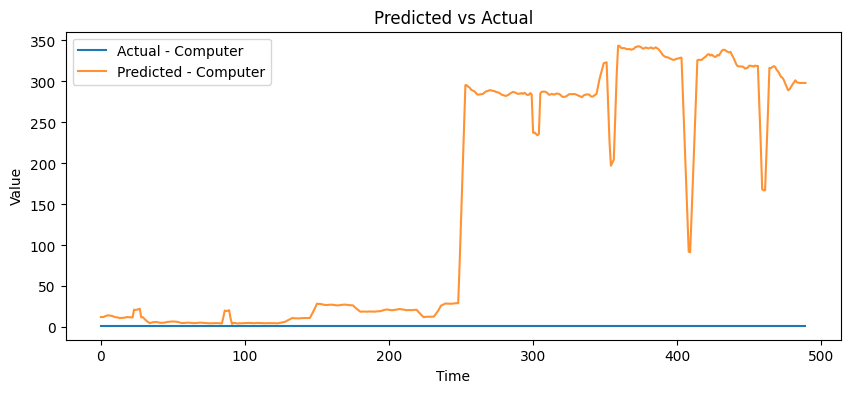

Computer: MAE=150.0500, RMSE=207.7947, R2=0.0000


In [16]:
val_preds = val_eval['predictions']
val_targets = val_eval['targets']
val_aggregates = val_eval['aggregates'].reshape(-1, 1)
visualize_actual_vs_predicted(
    [val_preds],
    [val_targets],
    [val_aggregates],
    devices,
    devices=['Computer'],
    start=10,
    end=500
)


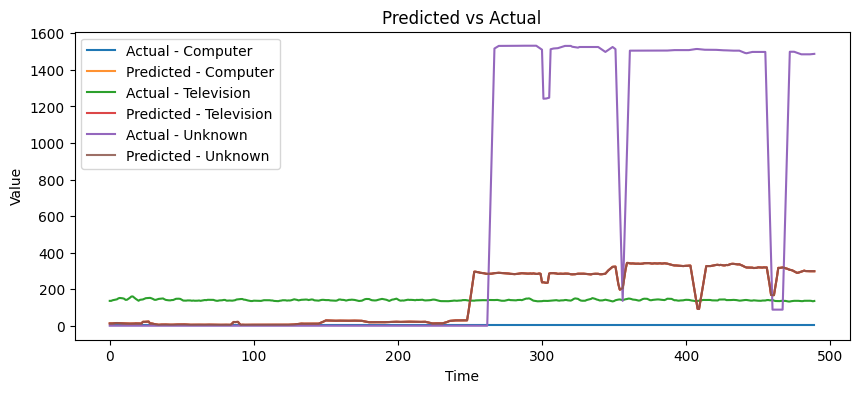

Computer: MAE=150.0500, RMSE=207.7947, R2=0.0000
Television: MAE=140.9485, RMSE=144.6816, R2=-1267.3197
Unknown: MAE=525.2419, RMSE=777.4718, R2=-0.1327


In [17]:
visualize_actual_vs_predicted(
    [val_preds],
    [val_targets],
    [val_aggregates],
    devices,
    devices=['Computer', 'Television', 'Unknown'],
    start=10,
    end=500,
)

In [18]:
val_samples = val_preds.shape[0]
start_offset = lookback - 1
val_base = val_df.iloc[start_offset:start_offset + val_samples].reset_index(drop=True)
pred_cols = [f'{device}_pred' for device in devices]
pred_df = pd.DataFrame(val_preds, columns=pred_cols)
result_df = pd.concat([val_base.reset_index(drop=True), pred_df], axis=1)
result_df.head()


,Aggregate,Hour,Unknown,Unknown_State,WashingMachine,WashingMachine_State,Dishwasher,Dishwasher_State,Dryer,Dryer_State,Television,Television_State,Computer,Computer_State,Unknown_pred,WashingMachine_pred,Dishwasher_pred,Dryer_pred,Television_pred,Computer_pred
0,369.2,15,0.0,OFF,1.8,OFF,0.0,OFF,0.0,OFF,136.4,ON,2.0,OFF,12.810673,12.810673,12.810673,12.810673,12.810673,12.810673
1,369.2,15,0.0,OFF,1.8,OFF,0.0,OFF,0.0,OFF,136.4,ON,2.0,OFF,12.777124,12.777122,12.777124,12.777124,12.777124,12.777124
2,369.0,15,0.0,OFF,2.0,OFF,0.0,OFF,0.0,OFF,136.4,ON,2.0,OFF,12.754955,12.754955,12.754955,12.754955,12.754955,12.754955
3,563.6,15,0.0,OFF,1.8,OFF,0.0,OFF,0.0,OFF,136.4,ON,2.0,OFF,38.197800,38.197800,38.197800,38.197800,38.197800,38.197800
4,758.2,15,0.0,OFF,1.8,OFF,0.0,OFF,0.0,OFF,136.4,ON,2.0,OFF,67.341248,67.341248,67.341240,67.341248,67.341248,67.341240


In [19]:
with torch.no_grad():
    emb = trained_model.node_embedding.weight.detach().cpu().numpy()
    for idx, name in enumerate(train_dataset.get_metadata().node_names):
        print(f"{idx:2d} {name:12s}  "
              f"norm={np.linalg.norm(emb[idx]):.4f}  "
              f"first3={emb[idx][:3]}")

 0 Total         norm=0.7283  first3=[ 0.28168163 -0.14016157  0.2080522 ]
 1 Residual      norm=0.9981  first3=[-0.34603554  0.34635964 -0.5261139 ]
 2 Unknown       norm=1.2138  first3=[0.5185937  0.40600023 0.17755902]
 3 WashingMachine  norm=0.9263  first3=[ 0.04397216 -0.5075872  -0.5884733 ]
 4 Dishwasher    norm=1.4191  first3=[-0.4391146 -0.6690053 -0.7087484]
 5 Dryer         norm=1.1527  first3=[-0.42480642 -0.57010967 -0.48622358]
 6 Television    norm=0.8209  first3=[ 0.16461018  0.36959454 -0.10886239]
 7 Computer      norm=0.9697  first3=[ 0.307871    0.13509376 -0.58012456]


In [15]:
status_df, metrics = classification(result_df, devices, return_metrics=True)
metrics


{'Unknown': {'accuracy': 0.9297618196123311,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'n': 41943},
 'WashingMachine': {'accuracy': 0.9801873971818897,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'n': 41943},
 'Dishwasher': {'accuracy': 0.981904012588513,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'n': 41943},
 'Dryer': {'accuracy': 0.9998569487161147,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'n': 41943},
 'Television': {'accuracy': 0.5174403356936795,
  'precision': 0.3817866769349249,
  'recall': 0.10430254576057227,
  'f1': 0.16384367512187062,
  'n': 41943},
 'Computer': {'accuracy': 0.7032877953412965,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'n': 41943}}

In [16]:
bundle = {
    'model_state': trained_model.state_dict(),
    'feature_scaler': train_dataset.get_feature_scaler(),
    'label_scaler': train_dataset.get_label_scaler(),
    'metadata': {
        'node_names': metadata.node_names,
        'device_names': metadata.device_names,
        'include_residual': metadata.include_residual,
        'lookback': lookback,
        'horizon': horizon
    },
    'config': config
}
model_path = config['model_save_path']
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(bundle, model_path)
result_df.to_csv('prediction_results.csv', index=False)
'Artifacts saved.'


'Artifacts saved.'